<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


In [51]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)


In [3]:
import feather

In [4]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import warnings

In [5]:
data = feather.read_dataframe('train_df_alpha')

In [6]:
for df in [data]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old', 'observation_date_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [7]:
cols_excluded = ['purchase_date_max', 'purchase_date_max_old', 'card_id', 'first_active_month',
                 'target','outliers','card_id_size', 'card_id_size_old', 
                 'purchase_date_min', 'purchase_date_min_old','first_active_monthYear',
                 'first_active_monthMonth',
                 'first_active_monthWeek',
                 'first_active_monthDay',
                 'first_active_monthDayofweek',
                 'first_active_monthDayofyear',
                 'first_active_monthIs_month_end',
                 'first_active_monthIs_month_start',
                 'first_active_monthIs_quarter_end',
                 'first_active_monthIs_quarter_start',
                 'first_active_monthIs_year_end',
                 'first_active_monthIs_year_start']

In [8]:
cols_included = ['feature_1','feature_2','feature_3','transactions_count','subsector_id_nunique','merchant_id_nunique','merchant_category_id_nunique','purchase_Month_mean','purchase_Month_min','purchase_Month_max','purchase_Week_nunique','purchase_Week_mean','purchase_Week_min','purchase_Week_max','purchase_Dayofweek_mean','purchase_Dayofweek_min','purchase_Dayofweek_max','purchase_Day_nunique','purchase_Day_mean','purchase_Day_min','purchase_Day_max','purchase_Hour_nunique','purchase_Hour_mean','purchase_Hour_min','purchase_Hour_max','purchase_amount_sum','purchase_amount_max','purchase_amount_min','purchase_amount_mean','purchase_amount_var','purchase_amount_skew','installments_sum','installments_max','installments_mean','installments_var','installments_skew','month_lag_max','month_lag_min','month_lag_mean','month_lag_var','month_lag_skew','month_diff_mean','month_diff_var','month_diff_skew','purchased_on_weekend_mean','category_1_mean','category_2_mean','category_3_mean','card_id_count','price_mean','price_max','price_min','price_var','Christmas_Day_2017_mean','Children_day_2017_mean','Black_Friday_2017_mean','Mothers_Day_2018_mean','duration_mean','duration_min','duration_max','duration_var','duration_skew','amount_month_ratio_mean','amount_month_ratio_min','amount_month_ratio_max','amount_month_ratio_var','amount_month_ratio_skew','category_2_mean_mean','category_3_mean_mean','purchase_date_diff','purchase_date_average','purchase_date_uptonow','purchase_date_uptomin','transactions_count_old','subsector_id_nunique_old','merchant_id_nunique_old','merchant_category_id_nunique_old','purchase_Month_nunique','purchase_Month_mean_old','purchase_Month_min_old','purchase_Month_max_old','purchase_Week_nunique_old','purchase_Week_mean_old','purchase_Week_min_old','purchase_Week_max_old','purchase_Dayofweek_mean_old','purchase_Day_nunique_old','purchase_Day_mean_old','purchase_Day_min_old','purchase_Hour_nunique_old','purchase_Hour_mean_old','purchase_Hour_min_old','purchase_Hour_max_old','purchase_amount_sum_old','purchase_amount_max_old','purchase_amount_min_old','purchase_amount_mean_old','purchase_amount_var_old','purchase_amount_skew_old','installments_sum_old','installments_max_old','installments_mean_old','installments_var_old','installments_skew_old','month_lag_max_old','month_lag_min_old','month_lag_mean_old','month_lag_var_old','month_lag_skew_old','month_diff_max','month_diff_min','month_diff_mean_old','month_diff_var_old','month_diff_skew_old','authorized_flag_mean','purchased_on_weekend_mean_old','category_1_mean_old','category_2_mean_old','category_3_mean_old','card_id_count_old','price_sum','price_mean_old','price_max_old','price_min_old','price_var_old','Christmas_Day_2017_mean_old','Mothers_Day_2017_mean','fathers_day_2017_mean','Children_day_2017_mean_old','Valentine_Day_2017_mean','Black_Friday_2017_mean_old','Mothers_Day_2018_mean_old','duration_mean_old','duration_min_old','duration_max_old','duration_var_old','duration_skew_old','amount_month_ratio_mean_old','amount_month_ratio_min_old','amount_month_ratio_max_old','amount_month_ratio_var_old','amount_month_ratio_skew_old','category_2_mean_mean_old','category_3_mean_mean_old','purchase_date_diff_old','purchase_date_average_old','purchase_date_uptonow_old','purchase_date_uptomin_old','quarter','observed_elapsed_time','days_feature1','days_feature2','days_feature3','days_feature1_ratio','days_feature2_ratio','days_feature3_ratio','feature_sum','feature_mean','feature_max','feature_min','feature_var','card_id_total','card_id_count_total','card_id_count_ratio','purchase_amount_total','purchase_amount_total_mean','purchase_amount_total_max','purchase_amount_total_min','purchase_amount_sum_ratio','hist_first_buy','new_first_buy','hist_last_buy','new_last_buy','month_diff_ratio','installments_total','installments_ratio','price_total','CLV','CLV_old','CLV_ratio']

In [5]:
data.head().T

,0,1,2,3,4
first_active_month,2017-06-01 00:00:00,2017-01-01 00:00:00,2016-08-01 00:00:00,2017-09-01 00:00:00,2017-11-01 00:00:00
card_id,C_ID_92a2005557,C_ID_3d0044924f,C_ID_d639edf6cd,C_ID_186d6a6901,C_ID_cdbd2c0db2
feature_1,0.0131446,0.0107116,0.0106099,0.0107116,0.00805849
feature_2,0.00875212,0.0113848,0.00875212,0.0141664,0.0141664
feature_3,0.0114275,0.0102828,0.0102828,0.0102828,0.0102828
target,-0.820283,0.392913,0.688056,0.142495,-0.159749
first_active_monthYear,2017,2017,2016,2017,2017
first_active_monthMonth,6,1,8,9,11
first_active_monthWeek,22,52,31,35,44
first_active_monthDay,1,1,1,1,1


In [9]:
train_columns = [c for c in cols_included if c not in cols_excluded]

In [10]:
vc = data['outliers'].value_counts().to_frame().reset_index()
vc['percent'] = vc["outliers"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "target", "outlier" : "Count"})
vc

,target,outliers,percent
0,0,199710,98.91
1,1,2207,1.09


In [11]:
non_fraud = data[data['outliers'] == 0].sample(8000)
fraud = data[data['outliers'] == 1]

In [12]:
non_fraud.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,transactions_count,subsector_id_nunique,merchant_id_nunique,merchant_category_id_nunique,...,purchase_amount_mean_ratio,purchase_amount_median_ratio,purchase_amount_max_total,purchase_amount_min_total,purchase_amount_skew_ratio,purchase_amount_before_after_ratio,purchase_amount_first_last_diff,purchase_amount_fi_last_old_total,purchase_amount_fi_last_new_total,outliers
124567,2017-09-01,C_ID_60d908b605,0.010610,0.008752,0.010283,-3.084045,2.0,2.0,2.0,2.0,...,0.793144,1.472642,545.0,76.80,NaN,0.568795,-293.90,0.00,-175.56,0
185709,2017-12-01,C_ID_96dbe61151,0.010479,0.008752,0.011428,-2.996163,3.0,3.0,3.0,3.0,...,0.960350,1.827243,160.0,26.20,-0.992871,0.314865,63.20,0.00,266.00,0
78875,2017-03-01,C_ID_18861a51ff,0.010479,0.014166,0.011428,1.364225,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4560.38,0
99986,2017-08-01,C_ID_b29ea595b4,0.010712,0.011385,0.010283,-0.821727,5.0,3.0,5.0,5.0,...,2.996620,1.225000,2503.1,37.90,0.652934,3.105951,1506.63,0.00,-36.40,0
30155,2017-01-01,C_ID_cb0b9a61df,0.010610,0.011385,0.010283,0.129980,7.0,7.0,7.0,7.0,...,0.611521,1.052125,456.0,27.76,0.264384,1.574198,157.98,-46.12,116.73,0


In [13]:
fraud.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,transactions_count,subsector_id_nunique,merchant_id_nunique,merchant_category_id_nunique,...,purchase_amount_mean_ratio,purchase_amount_median_ratio,purchase_amount_max_total,purchase_amount_min_total,purchase_amount_skew_ratio,purchase_amount_before_after_ratio,purchase_amount_first_last_diff,purchase_amount_fi_last_old_total,purchase_amount_fi_last_new_total,outliers
64,2017-09-01,C_ID_8186f3fcc1,0.010479,0.011385,0.011428,-33.219281,12.0,8.0,12.0,9.0,...,0.530570,0.710754,1413.36,17.79,0.348602,0.540376,350.64,283.82,200.18,1
92,2015-05-01,C_ID_b9379a30ea,0.010479,0.014166,0.011428,-33.219281,5.0,4.0,5.0,4.0,...,12.996096,1.712150,925.66,17.00,1.147959,18.578699,937.94,0.00,5.39,1
125,2015-10-01,C_ID_e9120f535c,0.010479,0.014166,0.011428,-33.219281,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-111.01,1
151,2017-03-01,C_ID_65715cb80d,0.010712,0.008752,0.010283,-33.219281,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.94,1
225,2017-01-01,C_ID_ae77d244b6,0.010610,0.011385,0.010283,-33.219281,3.0,2.0,3.0,3.0,...,3.705176,1.105354,458.00,5.50,0.704212,1.401186,303.19,0.00,201.69,1


In [30]:
DataFrameSummary(non_fraud).summary().T

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/lib/function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
first_active_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,61,0,0%,date
card_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,4000,0,0%,unique
feature_1,4000,0.010958,0.0012535,0.00805849,0.0104794,0.0106099,0.0107116,0.0131446,4000,5,0,0%,numeric
feature_2,4000,0.0109406,0.00194276,0.00875212,0.00875212,0.0113848,0.0113848,0.0141664,4000,3,0,0%,numeric
feature_3,4000,0.0109413,0.000565895,0.0102828,0.0102828,0.0114275,0.0114275,0.0114275,4000,2,0,0%,bool
target,4000,-0.0563465,1.71308,-10.0498,-0.872702,-0.00405931,0.772661,10.1888,4000,3962,0,0%,numeric
first_active_monthYear,4000,2016.52,0.767591,2011,2016,2017,2017,2017,4000,7,0,0%,numeric
first_active_monthMonth,4000,7.44775,3.32296,1,5,8,10,12,4000,12,0,0%,numeric
first_active_monthWeek,4000,31.313,13.6765,1,22,31,44,53,4000,21,0,0%,numeric
first_active_monthDay,4000,1,0,1,1,1,1,1,4000,1,0,0%,constant


In [31]:
DataFrameSummary(fraud).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
first_active_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2207,65,0,0%,date
card_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2207,2207,0,0%,unique
feature_1,2207,0.0110753,0.0012774,0.00805849,0.0104794,0.0106099,0.0107116,0.0131446,2207,5,0,0%,numeric
feature_2,2207,0.011279,0.00198159,0.00875212,0.00875212,0.0113848,0.0113848,0.0141664,2207,3,0,0%,numeric
feature_3,2207,0.0109597,0.000562848,0.0102828,0.0102828,0.0114275,0.0114275,0.0114275,2207,2,0,0%,bool
target,2207,-33.2193,7.10704e-15,-33.2193,-33.2193,-33.2193,-33.2193,-33.2193,2207,1,0,0%,constant
first_active_monthYear,2207,2016.19,0.950668,2012,2016,2016,2017,2017,2207,6,0,0%,numeric
first_active_monthMonth,2207,6.31264,3.51143,1,3,6,9,12,2207,12,0,0%,numeric
first_active_monthWeek,2207,28.2981,15.3947,1,13,26,44,53,2207,21,0,0%,numeric
first_active_monthDay,2207,1,0,1,1,1,1,1,2207,1,0,0%,constant


In [16]:
non_fraud.shape, fraud.shape

((8000, 352), (2207, 352))

In [28]:
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True).copy()

In [29]:
df.fillna(0, inplace=True)
df.replace(-np.inf, 0, inplace=True)
df.replace(np.inf, 0, inplace=True)

In [30]:
X = df[train_columns].values
Y = df["outliers"].values

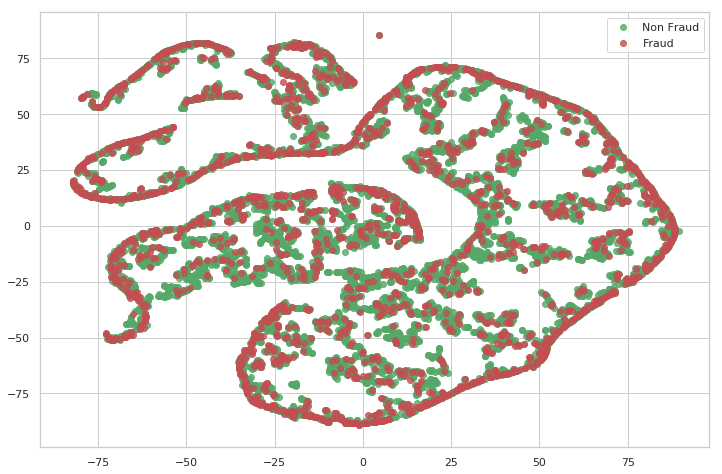

In [31]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [32]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [33]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [34]:
x = data[train_columns]
y = data["outliers"].values

# imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
# x = imp.fit_transform(x)

In [35]:
x.fillna(0, inplace=True)
x.replace(-np.inf, 0, inplace=True)
x.replace(np.inf, 0, inplace=True)

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [36]:
x.shape, y.shape

((201917, 180), (201917,))

In [37]:
x_scale = preprocessing.MinMaxScaler().fit_transform(x)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [53]:
%%time
autoencoder.fit(x_norm, x_norm, 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Train on 159768 samples, validate on 39942 samples
Epoch 1/10
159768/159768 [==============================] - 2s 10us/step - loss: 0.2674 - val_loss: 0.2257
Epoch 2/10
159768/159768 [==============================] - 2s 10us/step - loss: 0.2597 - val_loss: 0.2177
Epoch 3/10
159768/159768 [==============================] - 2s 10us/step - loss: 0.2567 - val_loss: 0.2111
Epoch 4/10
159768/159768 [==============================] - 2s 11us/step - loss: 0.2505 - val_loss: 0.2189
Epoch 5/10
159768/159768 [==============================] - 2s 10us/step - loss: 0.2441 - val_loss: 0.2134
Epoch 6/10
159768/159768 [==============================] - 2s 10us/step - loss: 0.2384 - val_loss: 0.2074
Epoch 7/10
159768/159768 [==============================] - 2s 10us/step - loss: 0.2338 - val_loss: 0.1745
Epoch 8/10
159768/159768 [==============================] - 2s 12us/step - loss: 0.2250 - val_loss: 0.1774
Epoch 9/10
159768/159768 [==============================] - 2s 11us/step - loss: 0.2164 - val

In [54]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [55]:
norm_hid_rep = hidden_representation.predict(x_norm[:6000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [56]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

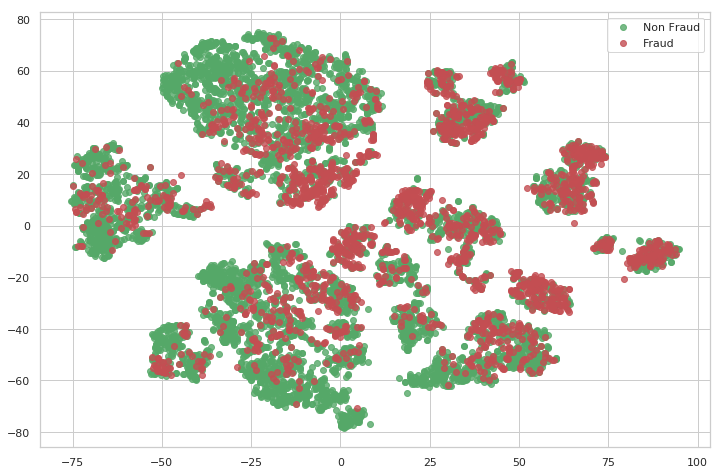

CPU times: user 42 s, sys: 0 ns, total: 42 s
Wall time: 42 s


In [57]:
%%time
tsne_plot(rep_x, rep_y, "latent_representation.png")

In [43]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))


Actual Representation (Before),Latent Representation (Actual)
,


In [58]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
print ("Accuracy Score: ", log_loss(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86      1517
         1.0       0.65      0.33      0.44       535

   micro avg       0.78      0.78      0.78      2052
   macro avg       0.72      0.64      0.65      2052
weighted avg       0.76      0.78      0.75      2052


Accuracy Score:  0.7792397660818714
Accuracy Score:  7.624826153920696
